### Load required libraries

In [102]:
import numpy as np
import pandas as pd
import seaborn as sns

import tensorflow as tf
import keras
from tensorflow.keras import regularizers
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Input
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

### Load the data

In [103]:
df = pd.read_csv('./data/creditcard.csv', index_col=0)
print(df.shape)
df.head()

(284807, 30)


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
Time,,,,,,,,,,,,,,,,,,,,,
0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


#### Data check

In [104]:
df['Class'].value_counts(normalize=True)

0    0.998273
1    0.001727
Name: Class, dtype: float64

In [105]:
df.columns

Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21',
       'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class'],
      dtype='object')

In [106]:
df.isnull().values.any()

False

In [107]:
df = df.drop(['Amount'], axis=1)

### Train/test split

In [108]:
frauds = df[df.Class == 1]
#normal = df[df.Class == 0].sample(10000)
normal = df[df.Class == 0]
print("Frauds shape: {}".format(frauds.shape))
print("Normal shape: {}".format(normal.shape))

Frauds shape: (492, 29)
Normal shape: (284315, 29)


In [109]:
data = pd.concat([frauds, normal])
data.shape

(284807, 29)

In [110]:
X_train, X_test = train_test_split(data, test_size=0.3, random_state=42)
X_train = X_train[X_train.Class == 0]
X_train = X_train.drop(['Class'], axis=1)

X_test, y_test = X_test.drop(['Class'], axis=1).values, X_test['Class'].values

print("X_train shape: {}".format(X_train.shape))
print("X_test shape: {}".format(X_test.shape))

X_train shape: (199013, 28)
X_test shape: (85443, 28)


### Visualize the data with TSNE and PCA

In [113]:
x1 = df[df.Class == 1]
x2 = df[df.Class == 0].sample(10000)

dfd = x1.append(x2)
x = dfd.drop(['Class'], axis=1)
y = dfd['Class'].values

SEED = 42

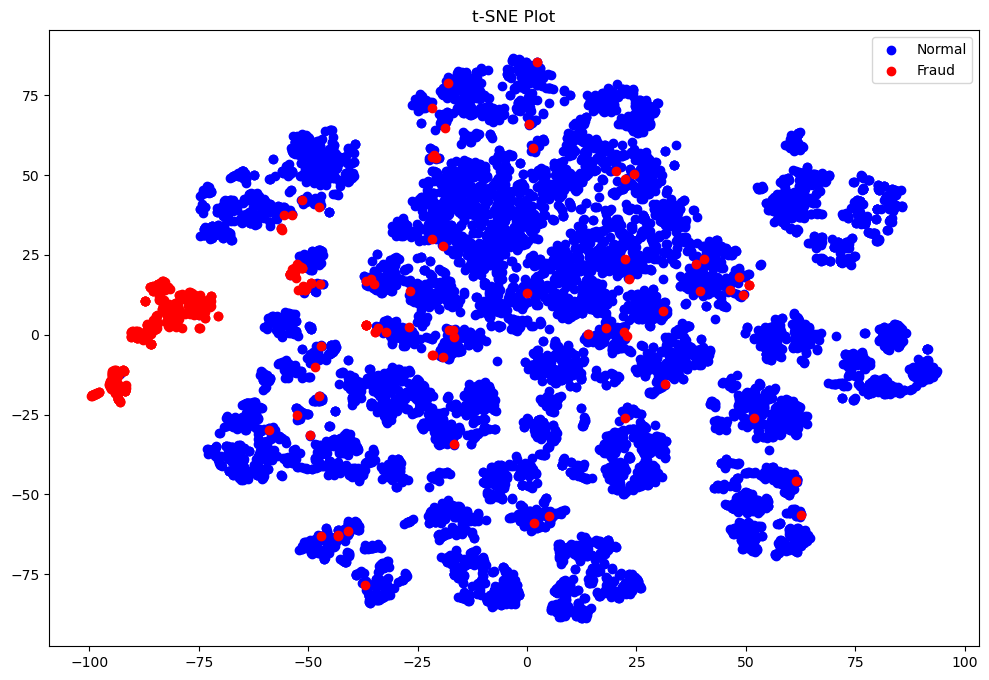

In [114]:
tsne = TSNE(n_components=2, random_state=SEED, init='random', learning_rate=200)
xtsne = tsne.fit_transform(x)
plt.figure(figsize=(12,8));
plt.scatter(xtsne[np.where(y==0), 0], y=xtsne[np.where(y==0), 1], color="blue", label='Normal')
plt.scatter(x=xtsne[np.where(y==1), 0], y=xtsne[np.where(y==1), 1], color="red", label='Fraud')
plt.title('t-SNE Plot')
plt.legend()
plt.show()

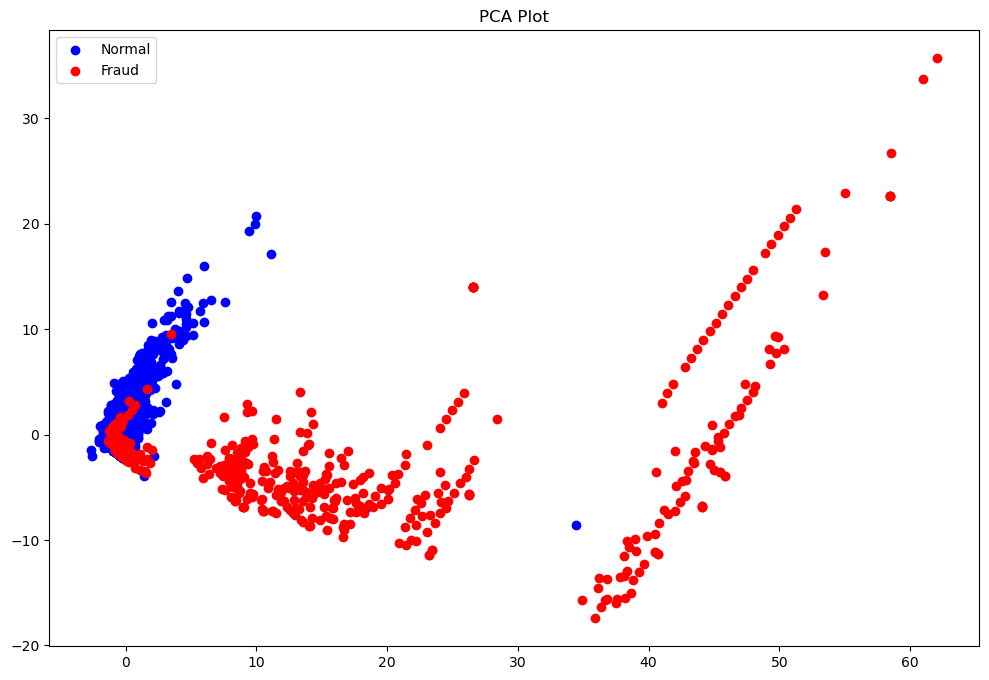

In [115]:
pca = PCA(n_components=2, random_state=SEED)
xpca = pca.fit_transform(x)
plt.figure(figsize=(12,8));
plt.scatter(x=xpca[np.where(y==0), 0], y=xpca[np.where(y==0), 1], color="blue", label='Normal')
plt.scatter(x=xpca[np.where(y==1), 0], y=xpca[np.where(y==1), 1], color="red", label='Fraud')
plt.title('PCA Plot')
plt.legend()
plt.show()

#### Normalize the data

In [45]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

scaler.fit_transform(X_train);
scaler.transform(X_test);

### Sparse AutoEncoder Model(L1)

In [46]:
input_dim = X_train.shape[1]

input_layer = Input(shape=(input_dim, ))
encoder = Dense(40, activation="elu",activity_regularizer=regularizers.l1(10e-5))(input_layer)

encoder = Dense(56, activation="elu",activity_regularizer=regularizers.l1(10e-5))(encoder)

decoder = Dense(40, activation='elu',activity_regularizer=regularizers.l1(10e-5))(encoder)
decoder = Dense(input_dim, activation='elu')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

In [47]:
epochs = 100
batch_size = 32
autoencoder.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath="fraudSpAE_L1.pth", verbose=0, save_best_only=True)

### Training

In [48]:
history = autoencoder.fit(np.array(X_train), np.array(X_train),
                    epochs=epochs,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_split=0.1,
                    callbacks=[checkpointer]).history

Epoch 1/100
5585/5598 [============================>.] - ETA: 0s - loss: 0.2926 - accuracy: 0.8833INFO:tensorflow:Assets written to: fraudSpAE_L1.pth\assets


INFO:tensorflow:Assets written to: fraudSpAE_L1.pth\assets


5598/5598 [==============================] - 33s 5ms/step - loss: 0.2924 - accuracy: 0.8834 - val_loss: 0.2414 - val_accuracy: 0.9238
Epoch 2/100
5597/5598 [============================>.] - ETA: 0s - loss: 0.2631 - accuracy: 0.9160INFO:tensorflow:Assets written to: fraudSpAE_L1.pth\assets


INFO:tensorflow:Assets written to: fraudSpAE_L1.pth\assets


5598/5598 [==============================] - 27s 5ms/step - loss: 0.2631 - accuracy: 0.9160 - val_loss: 0.2403 - val_accuracy: 0.9007
Epoch 3/100
5589/5598 [============================>.] - ETA: 0s - loss: 0.2605 - accuracy: 0.9145INFO:tensorflow:Assets written to: fraudSpAE_L1.pth\assets


INFO:tensorflow:Assets written to: fraudSpAE_L1.pth\assets


5598/5598 [==============================] - 26s 5ms/step - loss: 0.2603 - accuracy: 0.9144 - val_loss: 0.2365 - val_accuracy: 0.9135
Epoch 4/100
5587/5598 [============================>.] - ETA: 0s - loss: 0.2550 - accuracy: 0.9209INFO:tensorflow:Assets written to: fraudSpAE_L1.pth\assets


INFO:tensorflow:Assets written to: fraudSpAE_L1.pth\assets


5598/5598 [==============================] - 31s 6ms/step - loss: 0.2548 - accuracy: 0.9209 - val_loss: 0.2311 - val_accuracy: 0.9251
Epoch 5/100
5590/5598 [============================>.] - ETA: 0s - loss: 0.2534 - accuracy: 0.9188INFO:tensorflow:Assets written to: fraudSpAE_L1.pth\assets


INFO:tensorflow:Assets written to: fraudSpAE_L1.pth\assets


5598/5598 [==============================] - 26s 5ms/step - loss: 0.2533 - accuracy: 0.9188 - val_loss: 0.2294 - val_accuracy: 0.9211
Epoch 6/100
5579/5598 [============================>.] - ETA: 0s - loss: 0.2515 - accuracy: 0.9193INFO:tensorflow:Assets written to: fraudSpAE_L1.pth\assets


INFO:tensorflow:Assets written to: fraudSpAE_L1.pth\assets


5598/5598 [==============================] - 25s 5ms/step - loss: 0.2517 - accuracy: 0.9193 - val_loss: 0.2282 - val_accuracy: 0.9310
Epoch 7/100
5597/5598 [============================>.] - ETA: 0s - loss: 0.2499 - accuracy: 0.9203INFO:tensorflow:Assets written to: fraudSpAE_L1.pth\assets


INFO:tensorflow:Assets written to: fraudSpAE_L1.pth\assets


5598/5598 [==============================] - 26s 5ms/step - loss: 0.2499 - accuracy: 0.9203 - val_loss: 0.2264 - val_accuracy: 0.9187
Epoch 8/100
5582/5598 [============================>.] - ETA: 0s - loss: 0.2504 - accuracy: 0.9201INFO:tensorflow:Assets written to: fraudSpAE_L1.pth\assets


INFO:tensorflow:Assets written to: fraudSpAE_L1.pth\assets


5598/5598 [==============================] - 23s 4ms/step - loss: 0.2502 - accuracy: 0.9202 - val_loss: 0.2236 - val_accuracy: 0.9290
Epoch 9/100
5598/5598 [==============================] - 20s 4ms/step - loss: 0.2494 - accuracy: 0.9208 - val_loss: 0.2259 - val_accuracy: 0.9311
Epoch 10/100
5598/5598 [==============================] - 22s 4ms/step - loss: 0.2492 - accuracy: 0.9222 - val_loss: 0.2258 - val_accuracy: 0.9291
Epoch 11/100
5591/5598 [============================>.] - ETA: 0s - loss: 0.2489 - accuracy: 0.9230INFO:tensorflow:Assets written to: fraudSpAE_L1.pth\assets


INFO:tensorflow:Assets written to: fraudSpAE_L1.pth\assets


5598/5598 [==============================] - 26s 5ms/step - loss: 0.2487 - accuracy: 0.9230 - val_loss: 0.2230 - val_accuracy: 0.9375
Epoch 12/100
5581/5598 [============================>.] - ETA: 0s - loss: 0.2478 - accuracy: 0.9253INFO:tensorflow:Assets written to: fraudSpAE_L1.pth\assets


INFO:tensorflow:Assets written to: fraudSpAE_L1.pth\assets


5598/5598 [==============================] - 24s 4ms/step - loss: 0.2480 - accuracy: 0.9254 - val_loss: 0.2228 - val_accuracy: 0.9403
Epoch 13/100
5598/5598 [==============================] - 20s 4ms/step - loss: 0.2468 - accuracy: 0.9282 - val_loss: 0.2254 - val_accuracy: 0.9288
Epoch 14/100
5598/5598 [==============================] - ETA: 0s - loss: 0.2469 - accuracy: 0.9279INFO:tensorflow:Assets written to: fraudSpAE_L1.pth\assets


INFO:tensorflow:Assets written to: fraudSpAE_L1.pth\assets


5598/5598 [==============================] - 25s 4ms/step - loss: 0.2469 - accuracy: 0.9279 - val_loss: 0.2218 - val_accuracy: 0.9420
Epoch 15/100
5598/5598 [==============================] - 25s 4ms/step - loss: 0.2461 - accuracy: 0.9306 - val_loss: 0.2341 - val_accuracy: 0.9143
Epoch 16/100
5580/5598 [============================>.] - ETA: 0s - loss: 0.2462 - accuracy: 0.9314INFO:tensorflow:Assets written to: fraudSpAE_L1.pth\assets


INFO:tensorflow:Assets written to: fraudSpAE_L1.pth\assets


5598/5598 [==============================] - 24s 4ms/step - loss: 0.2461 - accuracy: 0.9314 - val_loss: 0.2210 - val_accuracy: 0.9440
Epoch 17/100
5598/5598 [==============================] - 21s 4ms/step - loss: 0.2456 - accuracy: 0.9321 - val_loss: 0.2225 - val_accuracy: 0.9370
Epoch 18/100
5598/5598 [==============================] - ETA: 0s - loss: 0.2455 - accuracy: 0.9342INFO:tensorflow:Assets written to: fraudSpAE_L1.pth\assets


INFO:tensorflow:Assets written to: fraudSpAE_L1.pth\assets


5598/5598 [==============================] - 27s 5ms/step - loss: 0.2455 - accuracy: 0.9342 - val_loss: 0.2208 - val_accuracy: 0.9450
Epoch 19/100
5598/5598 [==============================] - 22s 4ms/step - loss: 0.2464 - accuracy: 0.9334 - val_loss: 0.2246 - val_accuracy: 0.9183
Epoch 20/100
5598/5598 [==============================] - 21s 4ms/step - loss: 0.2463 - accuracy: 0.9332 - val_loss: 0.2226 - val_accuracy: 0.9393
Epoch 21/100
5597/5598 [============================>.] - ETA: 0s - loss: 0.2449 - accuracy: 0.9376INFO:tensorflow:Assets written to: fraudSpAE_L1.pth\assets


INFO:tensorflow:Assets written to: fraudSpAE_L1.pth\assets


5598/5598 [==============================] - 26s 5ms/step - loss: 0.2449 - accuracy: 0.9376 - val_loss: 0.2206 - val_accuracy: 0.9409
Epoch 22/100
5598/5598 [==============================] - 27s 5ms/step - loss: 0.2445 - accuracy: 0.9380 - val_loss: 0.2272 - val_accuracy: 0.9288
Epoch 23/100
5598/5598 [==============================] - 30s 5ms/step - loss: 0.2450 - accuracy: 0.9358 - val_loss: 0.2280 - val_accuracy: 0.9112
Epoch 24/100
5598/5598 [==============================] - 22s 4ms/step - loss: 0.2444 - accuracy: 0.9384 - val_loss: 0.2230 - val_accuracy: 0.9305
Epoch 25/100
5592/5598 [============================>.] - ETA: 0s - loss: 0.2443 - accuracy: 0.9381INFO:tensorflow:Assets written to: fraudSpAE_L1.pth\assets


INFO:tensorflow:Assets written to: fraudSpAE_L1.pth\assets


5598/5598 [==============================] - 29s 5ms/step - loss: 0.2446 - accuracy: 0.9381 - val_loss: 0.2204 - val_accuracy: 0.9426
Epoch 26/100
5592/5598 [============================>.] - ETA: 0s - loss: 0.2442 - accuracy: 0.9398INFO:tensorflow:Assets written to: fraudSpAE_L1.pth\assets


INFO:tensorflow:Assets written to: fraudSpAE_L1.pth\assets


5598/5598 [==============================] - 27s 5ms/step - loss: 0.2441 - accuracy: 0.9398 - val_loss: 0.2196 - val_accuracy: 0.9509
Epoch 27/100
5598/5598 [==============================] - 23s 4ms/step - loss: 0.2442 - accuracy: 0.9395 - val_loss: 0.2211 - val_accuracy: 0.9407
Epoch 28/100
5598/5598 [==============================] - 22s 4ms/step - loss: 0.2447 - accuracy: 0.9375 - val_loss: 0.2245 - val_accuracy: 0.9263
Epoch 29/100
5598/5598 [==============================] - 21s 4ms/step - loss: 0.2440 - accuracy: 0.9392 - val_loss: 0.2255 - val_accuracy: 0.9256
Epoch 30/100
5598/5598 [==============================] - 24s 4ms/step - loss: 0.2437 - accuracy: 0.9399 - val_loss: 0.2239 - val_accuracy: 0.9285
Epoch 31/100
5597/5598 [============================>.] - ETA: 0s - loss: 0.2438 - accuracy: 0.9404INFO:tensorflow:Assets written to: fraudSpAE_L1.pth\assets


INFO:tensorflow:Assets written to: fraudSpAE_L1.pth\assets


5598/5598 [==============================] - 24s 4ms/step - loss: 0.2438 - accuracy: 0.9404 - val_loss: 0.2191 - val_accuracy: 0.9539
Epoch 32/100
5598/5598 [==============================] - 22s 4ms/step - loss: 0.2440 - accuracy: 0.9409 - val_loss: 0.2323 - val_accuracy: 0.9060
Epoch 33/100
5598/5598 [==============================] - 25s 5ms/step - loss: 0.2439 - accuracy: 0.9405 - val_loss: 0.2205 - val_accuracy: 0.9481
Epoch 34/100
5598/5598 [==============================] - 25s 4ms/step - loss: 0.2431 - accuracy: 0.9427 - val_loss: 0.2257 - val_accuracy: 0.9280
Epoch 35/100
5580/5598 [============================>.] - ETA: 0s - loss: 0.2433 - accuracy: 0.9418INFO:tensorflow:Assets written to: fraudSpAE_L1.pth\assets


INFO:tensorflow:Assets written to: fraudSpAE_L1.pth\assets


5598/5598 [==============================] - 26s 5ms/step - loss: 0.2430 - accuracy: 0.9418 - val_loss: 0.2189 - val_accuracy: 0.9510
Epoch 36/100
5598/5598 [==============================] - 25s 4ms/step - loss: 0.2438 - accuracy: 0.9402 - val_loss: 0.2203 - val_accuracy: 0.9532
Epoch 37/100
5583/5598 [============================>.] - ETA: 0s - loss: 0.2437 - accuracy: 0.9417INFO:tensorflow:Assets written to: fraudSpAE_L1.pth\assets


INFO:tensorflow:Assets written to: fraudSpAE_L1.pth\assets


5598/5598 [==============================] - 27s 5ms/step - loss: 0.2434 - accuracy: 0.9417 - val_loss: 0.2185 - val_accuracy: 0.9448
Epoch 38/100
5598/5598 [==============================] - 22s 4ms/step - loss: 0.2434 - accuracy: 0.9411 - val_loss: 0.2214 - val_accuracy: 0.9412
Epoch 39/100
5598/5598 [==============================] - 24s 4ms/step - loss: 0.2436 - accuracy: 0.9412 - val_loss: 0.2192 - val_accuracy: 0.9558
Epoch 40/100
5598/5598 [==============================] - 23s 4ms/step - loss: 0.2426 - accuracy: 0.9443 - val_loss: 0.2269 - val_accuracy: 0.9157
Epoch 41/100
5598/5598 [==============================] - 22s 4ms/step - loss: 0.2431 - accuracy: 0.9426 - val_loss: 0.2228 - val_accuracy: 0.9420
Epoch 42/100
5598/5598 [==============================] - 26s 5ms/step - loss: 0.2428 - accuracy: 0.9441 - val_loss: 0.2186 - val_accuracy: 0.9552
Epoch 43/100
5598/5598 [==============================] - 24s 4ms/step - loss: 0.2430 - accuracy: 0.9438 - val_loss: 0.2207 - val_a

INFO:tensorflow:Assets written to: fraudSpAE_L1.pth\assets


5598/5598 [==============================] - 26s 5ms/step - loss: 0.2429 - accuracy: 0.9448 - val_loss: 0.2180 - val_accuracy: 0.9563
Epoch 49/100
5598/5598 [==============================] - 22s 4ms/step - loss: 0.2428 - accuracy: 0.9438 - val_loss: 0.2195 - val_accuracy: 0.9394
Epoch 50/100
5598/5598 [==============================] - 23s 4ms/step - loss: 0.2422 - accuracy: 0.9450 - val_loss: 0.2195 - val_accuracy: 0.9553
Epoch 51/100
5598/5598 [==============================] - 23s 4ms/step - loss: 0.2428 - accuracy: 0.9437 - val_loss: 0.2186 - val_accuracy: 0.9547
Epoch 52/100
5587/5598 [============================>.] - ETA: 0s - loss: 0.2427 - accuracy: 0.9448INFO:tensorflow:Assets written to: fraudSpAE_L1.pth\assets


INFO:tensorflow:Assets written to: fraudSpAE_L1.pth\assets


5598/5598 [==============================] - 24s 4ms/step - loss: 0.2425 - accuracy: 0.9448 - val_loss: 0.2180 - val_accuracy: 0.9577
Epoch 53/100
5598/5598 [==============================] - 23s 4ms/step - loss: 0.2419 - accuracy: 0.9465 - val_loss: 0.2205 - val_accuracy: 0.9445
Epoch 54/100
5598/5598 [==============================] - ETA: 0s - loss: 0.2423 - accuracy: 0.9455INFO:tensorflow:Assets written to: fraudSpAE_L1.pth\assets


INFO:tensorflow:Assets written to: fraudSpAE_L1.pth\assets


5598/5598 [==============================] - 26s 5ms/step - loss: 0.2423 - accuracy: 0.9455 - val_loss: 0.2179 - val_accuracy: 0.9526
Epoch 55/100
5589/5598 [============================>.] - ETA: 0s - loss: 0.2428 - accuracy: 0.9442INFO:tensorflow:Assets written to: fraudSpAE_L1.pth\assets


INFO:tensorflow:Assets written to: fraudSpAE_L1.pth\assets


5598/5598 [==============================] - 26s 5ms/step - loss: 0.2427 - accuracy: 0.9442 - val_loss: 0.2177 - val_accuracy: 0.9517
Epoch 56/100
5598/5598 [==============================] - 24s 4ms/step - loss: 0.2419 - accuracy: 0.9473 - val_loss: 0.2181 - val_accuracy: 0.9513
Epoch 57/100
5598/5598 [==============================] - 23s 4ms/step - loss: 0.2417 - accuracy: 0.9473 - val_loss: 0.2190 - val_accuracy: 0.9478
Epoch 58/100
5598/5598 [==============================] - 23s 4ms/step - loss: 0.2421 - accuracy: 0.9451 - val_loss: 0.2261 - val_accuracy: 0.9278
Epoch 59/100
5598/5598 [==============================] - 23s 4ms/step - loss: 0.2422 - accuracy: 0.9460 - val_loss: 0.2201 - val_accuracy: 0.9424
Epoch 60/100
5598/5598 [==============================] - 25s 4ms/step - loss: 0.2431 - accuracy: 0.9447 - val_loss: 0.2209 - val_accuracy: 0.9410
Epoch 61/100
5589/5598 [============================>.] - ETA: 0s - loss: 0.2414 - accuracy: 0.9485INFO:tensorflow:Assets written t

INFO:tensorflow:Assets written to: fraudSpAE_L1.pth\assets


5598/5598 [==============================] - 27s 5ms/step - loss: 0.2414 - accuracy: 0.9485 - val_loss: 0.2175 - val_accuracy: 0.9568
Epoch 62/100
5593/5598 [============================>.] - ETA: 0s - loss: 0.2418 - accuracy: 0.9472INFO:tensorflow:Assets written to: fraudSpAE_L1.pth\assets


INFO:tensorflow:Assets written to: fraudSpAE_L1.pth\assets


5598/5598 [==============================] - 31s 5ms/step - loss: 0.2417 - accuracy: 0.9473 - val_loss: 0.2174 - val_accuracy: 0.9562
Epoch 63/100
5598/5598 [==============================] - 24s 4ms/step - loss: 0.2417 - accuracy: 0.9474 - val_loss: 0.2178 - val_accuracy: 0.9526
Epoch 64/100
5598/5598 [==============================] - 24s 4ms/step - loss: 0.2415 - accuracy: 0.9476 - val_loss: 0.2195 - val_accuracy: 0.9413
Epoch 65/100
5587/5598 [============================>.] - ETA: 0s - loss: 0.2423 - accuracy: 0.9469INFO:tensorflow:Assets written to: fraudSpAE_L1.pth\assets


INFO:tensorflow:Assets written to: fraudSpAE_L1.pth\assets


5598/5598 [==============================] - 25s 5ms/step - loss: 0.2421 - accuracy: 0.9470 - val_loss: 0.2173 - val_accuracy: 0.9531
Epoch 66/100
5598/5598 [==============================] - 24s 4ms/step - loss: 0.2413 - accuracy: 0.9487 - val_loss: 0.2223 - val_accuracy: 0.9451
Epoch 67/100
5598/5598 [==============================] - 22s 4ms/step - loss: 0.2414 - accuracy: 0.9507 - val_loss: 0.2179 - val_accuracy: 0.9560
Epoch 68/100
5598/5598 [==============================] - 23s 4ms/step - loss: 0.2412 - accuracy: 0.9489 - val_loss: 0.2181 - val_accuracy: 0.9503
Epoch 69/100
5598/5598 [==============================] - 24s 4ms/step - loss: 0.2415 - accuracy: 0.9497 - val_loss: 0.2177 - val_accuracy: 0.9581
Epoch 70/100
5598/5598 [==============================] - 23s 4ms/step - loss: 0.2415 - accuracy: 0.9498 - val_loss: 0.2174 - val_accuracy: 0.9550
Epoch 71/100
5598/5598 [==============================] - 20s 4ms/step - loss: 0.2412 - accuracy: 0.9500 - val_loss: 0.2193 - val_a

INFO:tensorflow:Assets written to: fraudSpAE_L1.pth\assets


5598/5598 [==============================] - 23s 4ms/step - loss: 0.2418 - accuracy: 0.9483 - val_loss: 0.2171 - val_accuracy: 0.9613
Epoch 74/100
5598/5598 [==============================] - 19s 3ms/step - loss: 0.2413 - accuracy: 0.9498 - val_loss: 0.2185 - val_accuracy: 0.9426
Epoch 75/100
5598/5598 [==============================] - 20s 4ms/step - loss: 0.2415 - accuracy: 0.9503 - val_loss: 0.2180 - val_accuracy: 0.9524
Epoch 76/100
5584/5598 [============================>.] - ETA: 0s - loss: 0.2415 - accuracy: 0.9502INFO:tensorflow:Assets written to: fraudSpAE_L1.pth\assets


INFO:tensorflow:Assets written to: fraudSpAE_L1.pth\assets


5598/5598 [==============================] - 22s 4ms/step - loss: 0.2413 - accuracy: 0.9502 - val_loss: 0.2171 - val_accuracy: 0.9617
Epoch 77/100
5598/5598 [==============================] - 21s 4ms/step - loss: 0.2414 - accuracy: 0.9511 - val_loss: 0.2194 - val_accuracy: 0.9532
Epoch 78/100
5598/5598 [==============================] - 19s 3ms/step - loss: 0.2408 - accuracy: 0.9525 - val_loss: 0.2234 - val_accuracy: 0.9296
Epoch 79/100
5598/5598 [==============================] - 22s 4ms/step - loss: 0.2418 - accuracy: 0.9502 - val_loss: 0.2183 - val_accuracy: 0.9569
Epoch 80/100
5598/5598 [==============================] - 21s 4ms/step - loss: 0.2410 - accuracy: 0.9511 - val_loss: 0.2172 - val_accuracy: 0.9613
Epoch 81/100
5598/5598 [==============================] - 24s 4ms/step - loss: 0.2415 - accuracy: 0.9507 - val_loss: 0.2171 - val_accuracy: 0.9578
Epoch 82/100
5598/5598 [==============================] - 21s 4ms/step - loss: 0.2415 - accuracy: 0.9508 - val_loss: 0.2174 - val_a

INFO:tensorflow:Assets written to: fraudSpAE_L1.pth\assets


5598/5598 [==============================] - 27s 5ms/step - loss: 0.2409 - accuracy: 0.9536 - val_loss: 0.2168 - val_accuracy: 0.9625
Epoch 85/100
5598/5598 [==============================] - 21s 4ms/step - loss: 0.2415 - accuracy: 0.9510 - val_loss: 0.2206 - val_accuracy: 0.9468
Epoch 86/100
5598/5598 [==============================] - 24s 4ms/step - loss: 0.2408 - accuracy: 0.9526 - val_loss: 0.2173 - val_accuracy: 0.9613
Epoch 87/100
5598/5598 [==============================] - 20s 4ms/step - loss: 0.2412 - accuracy: 0.9515 - val_loss: 0.2193 - val_accuracy: 0.9510
Epoch 88/100
5598/5598 [==============================] - 20s 4ms/step - loss: 0.2415 - accuracy: 0.9521 - val_loss: 0.2182 - val_accuracy: 0.9569
Epoch 89/100
5598/5598 [==============================] - 25s 4ms/step - loss: 0.2412 - accuracy: 0.9536 - val_loss: 0.2169 - val_accuracy: 0.9552
Epoch 90/100
5598/5598 [==============================] - 22s 4ms/step - loss: 0.2410 - accuracy: 0.9533 - val_loss: 0.2184 - val_a

INFO:tensorflow:Assets written to: fraudSpAE_L1.pth\assets


5598/5598 [==============================] - 22s 4ms/step - loss: 0.2410 - accuracy: 0.9533 - val_loss: 0.2166 - val_accuracy: 0.9618
Epoch 97/100
5598/5598 [==============================] - 20s 4ms/step - loss: 0.2410 - accuracy: 0.9533 - val_loss: 0.2173 - val_accuracy: 0.9601
Epoch 98/100
5581/5598 [============================>.] - ETA: 0s - loss: 0.2408 - accuracy: 0.9541INFO:tensorflow:Assets written to: fraudSpAE_L1.pth\assets


INFO:tensorflow:Assets written to: fraudSpAE_L1.pth\assets


5598/5598 [==============================] - 23s 4ms/step - loss: 0.2406 - accuracy: 0.9541 - val_loss: 0.2165 - val_accuracy: 0.9670
Epoch 99/100
5598/5598 [==============================] - 20s 4ms/step - loss: 0.2406 - accuracy: 0.9548 - val_loss: 0.2172 - val_accuracy: 0.9608
Epoch 100/100
5598/5598 [==============================] - 19s 3ms/step - loss: 0.2409 - accuracy: 0.9539 - val_loss: 0.2192 - val_accuracy: 0.9500


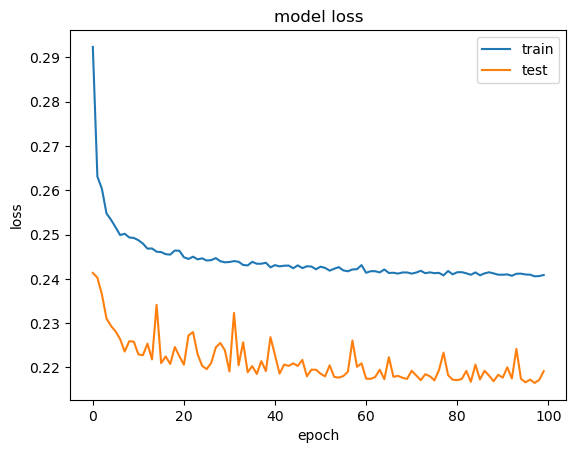

In [49]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

### Test

In [50]:
autoencoder = load_model('fraudSpAE_L1.pth')

In [51]:
predictions = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})
error_df.describe()

2671/2671 [==============================] - 7s 2ms/step


,reconstruction_error,true_class
count,85443.000000,85443.00000
mean,0.259113,0.00165
std,2.965597,0.04059
min,0.000070,0.00000
25%,0.004801,0.00000
50%,0.028143,0.00000
75%,0.092230,0.00000
max,342.188955,1.00000


In [52]:
threshold = 2.9

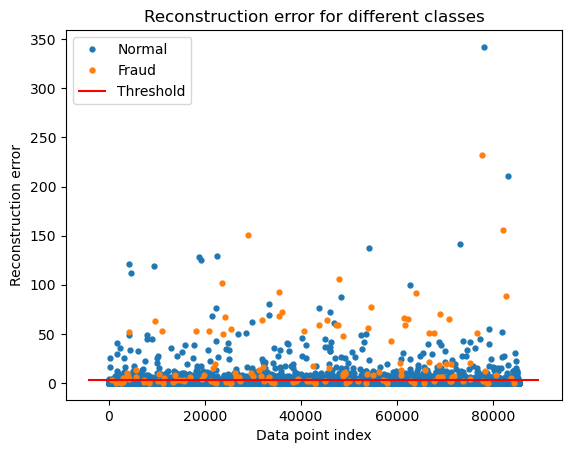

In [53]:
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

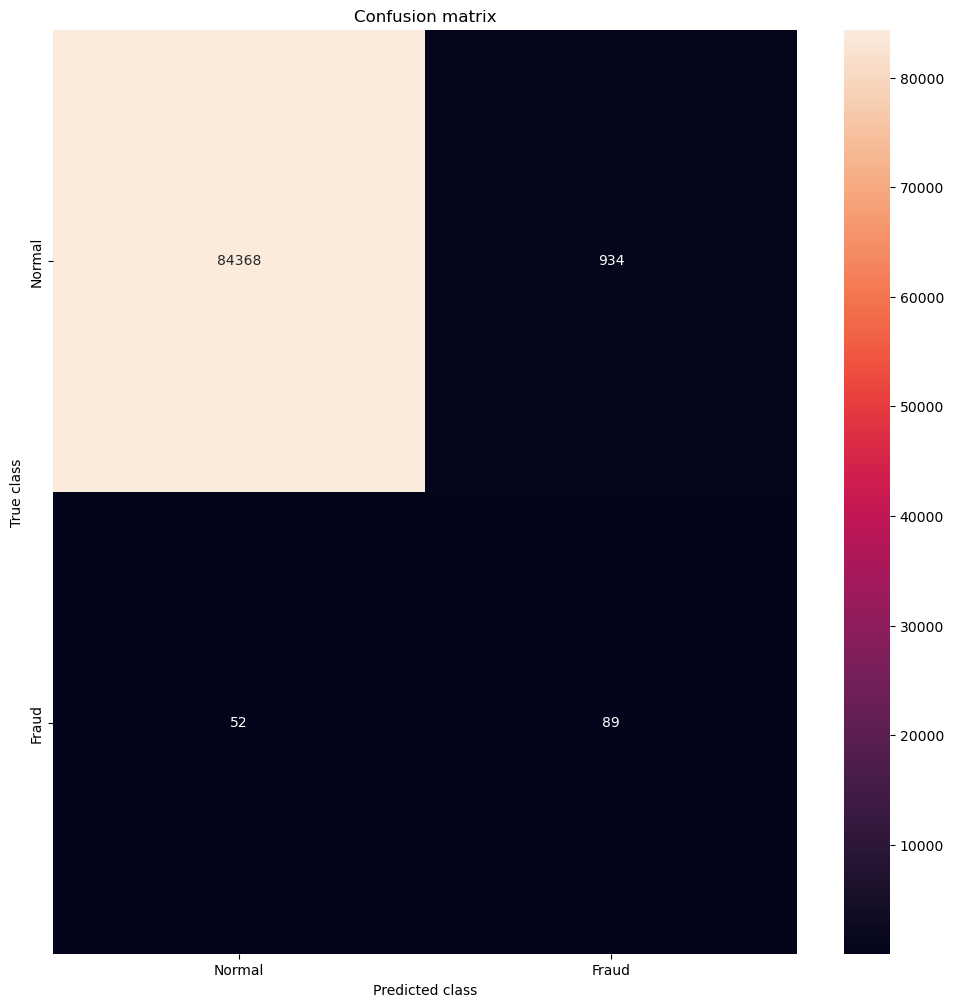

In [54]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
LABELS = ['Normal','Fraud']

y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

### Visualize the latent space

In [55]:
inp_layer = autoencoder.input
out_layer = autoencoder.layers[2].output

encoder = Model(inputs=inp_layer, outputs=out_layer)

In [56]:
encoder.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28)]              0         
                                                                 
 dense_4 (Dense)             (None, 40)                1160      
                                                                 
 dense_5 (Dense)             (None, 56)                2296      
                                                                 
Total params: 3456 (13.50 KB)
Trainable params: 3456 (13.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [57]:
fraud = X_test[y_test==1]
normal = X_test[y_test==0]

features = np.append(fraud, normal, axis=0)
labels = np.append(np.ones(len(fraud)), np.zeros(len(normal)))

latent_vector = encoder.predict(features)

2671/2671 [==============================] - 6s 2ms/step


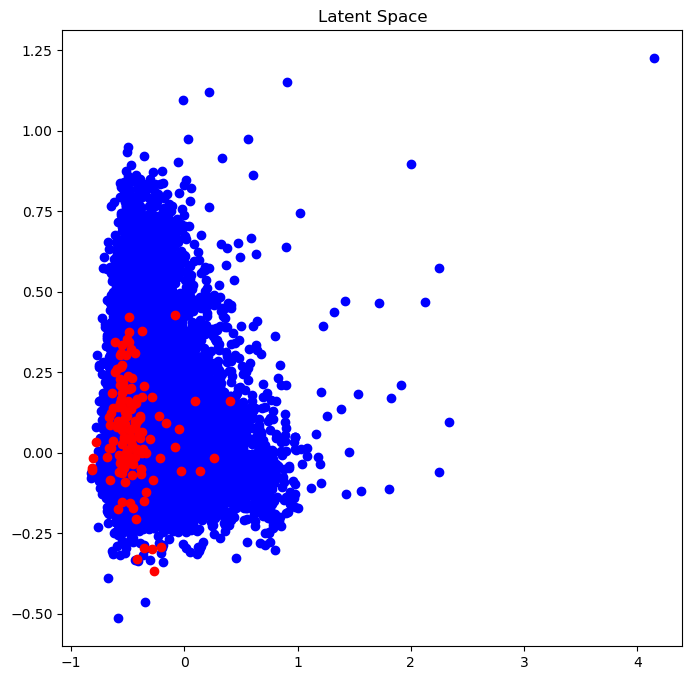

In [58]:
X = latent_vector[:,0]
y = latent_vector[:,1]

plt.subplots(figsize=(8, 8))
plt.scatter(X[labels==0], y[labels==0], color="blue", label='Normal')
plt.scatter(X[labels==1], y[labels==1], color="red", label='Fraud')

plt.title('Latent Space')
plt.show()

### Sparse AutoEncoder Model(KL Reg)

In [45]:
input_dim1 = X_train.shape[1]

input_layer1 = Input(shape=(input_dim1, ))
encoder1 = Dense(40, activation="relu")(input_layer1)

encoder1 = Dense(56, activation="relu")(encoder1)

decoder1 = Dense(40, activation='relu')(encoder1)
decoder1 = Dense(input_dim1, activation='relu')(decoder1)

autoencoder1 = Model(inputs=input_layer1, outputs=decoder1)

#### Def sparse_regularizer

In [62]:
from keras import backend as K
from keras.losses import mse, kld


# def kl_divergence(rho, rho_hat):
#     rho_hat = K.mean(K.sigmoid(rho_hat), axis=1)
#     rho = K.constant([rho] * K.shape(rho_hat)[0])
#     return K.sum(rho * K.log(rho / rho_hat) + (1 - rho) * K.log((1 - rho) / (1 - rho_hat)))

# def sparse_loss(rho, data):
#     values = data
#     loss = 0
#     for layer in autoencoder1.layers:
#         values = layer(values)
#         loss += kl_divergence(rho, values)
#     return loss

def custom_loss(y_true, y_pred):
    mse_loss = mse(y_true, y_pred);
    sparsity = kld(y_true, y_pred);
    beta = 0.001
    
    loss = mse_loss + beta*sparsity
    return loss;

In [63]:
epochs = 100
batch_size = 32

autoencoder1.compile(optimizer='adam', loss=custom_loss, metrics=['accuracy'])
checkpointer1 = ModelCheckpoint(filepath="fraudSpAE_KL.pth", verbose=0, save_best_only=True)

### Training

In [64]:
history1 = autoencoder1.fit(np.array(X_train), np.array(X_train),
                    epochs=epochs,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_split=0.1,
                    callbacks=[checkpointer1]).history

Epoch 1/100
5584/5598 [============================>.] - ETA: 0s - loss: 0.7079 - accuracy: 0.8099INFO:tensorflow:Assets written to: fraudSpAE_KL.pth\assets


INFO:tensorflow:Assets written to: fraudSpAE_KL.pth\assets


5598/5598 [==============================] - 17s 3ms/step - loss: 0.7078 - accuracy: 0.8100 - val_loss: 0.6735 - val_accuracy: 0.8433
Epoch 2/100
5581/5598 [============================>.] - ETA: 0s - loss: 0.6991 - accuracy: 0.8338INFO:tensorflow:Assets written to: fraudSpAE_KL.pth\assets


INFO:tensorflow:Assets written to: fraudSpAE_KL.pth\assets


5598/5598 [==============================] - 17s 3ms/step - loss: 0.6989 - accuracy: 0.8339 - val_loss: 0.6634 - val_accuracy: 0.8505
Epoch 3/100
5583/5598 [============================>.] - ETA: 0s - loss: 0.6822 - accuracy: 0.8429INFO:tensorflow:Assets written to: fraudSpAE_KL.pth\assets


INFO:tensorflow:Assets written to: fraudSpAE_KL.pth\assets


5598/5598 [==============================] - 15s 3ms/step - loss: 0.6819 - accuracy: 0.8430 - val_loss: 0.6399 - val_accuracy: 0.8846
Epoch 4/100
5598/5598 [==============================] - 18s 3ms/step - loss: 0.6729 - accuracy: 0.8672 - val_loss: 0.6413 - val_accuracy: 0.8813
Epoch 5/100
5598/5598 [==============================] - 14s 3ms/step - loss: 0.6712 - accuracy: 0.8755 - val_loss: 0.6404 - val_accuracy: 0.8913
Epoch 6/100
5598/5598 [==============================] - 14s 3ms/step - loss: 0.6696 - accuracy: 0.8844 - val_loss: 0.6452 - val_accuracy: 0.8569
Epoch 7/100
5593/5598 [============================>.] - ETA: 0s - loss: 0.6709 - accuracy: 0.8766INFO:tensorflow:Assets written to: fraudSpAE_KL.pth\assets


INFO:tensorflow:Assets written to: fraudSpAE_KL.pth\assets


5598/5598 [==============================] - 15s 3ms/step - loss: 0.6709 - accuracy: 0.8766 - val_loss: 0.6382 - val_accuracy: 0.8891
Epoch 8/100
5590/5598 [============================>.] - ETA: 0s - loss: 0.6641 - accuracy: 0.8917INFO:tensorflow:Assets written to: fraudSpAE_KL.pth\assets


INFO:tensorflow:Assets written to: fraudSpAE_KL.pth\assets


5598/5598 [==============================] - 15s 3ms/step - loss: 0.6640 - accuracy: 0.8918 - val_loss: 0.6300 - val_accuracy: 0.9055
Epoch 9/100
5598/5598 [==============================] - 13s 2ms/step - loss: 0.6623 - accuracy: 0.8828 - val_loss: 0.6334 - val_accuracy: 0.8758
Epoch 10/100
5587/5598 [============================>.] - ETA: 0s - loss: 0.6605 - accuracy: 0.8882INFO:tensorflow:Assets written to: fraudSpAE_KL.pth\assets


INFO:tensorflow:Assets written to: fraudSpAE_KL.pth\assets


5598/5598 [==============================] - 13s 2ms/step - loss: 0.6604 - accuracy: 0.8882 - val_loss: 0.6299 - val_accuracy: 0.9039
Epoch 11/100
5598/5598 [==============================] - 13s 2ms/step - loss: 0.6597 - accuracy: 0.8904 - val_loss: 0.6313 - val_accuracy: 0.8891
Epoch 12/100
5579/5598 [============================>.] - ETA: 0s - loss: 0.6595 - accuracy: 0.8905INFO:tensorflow:Assets written to: fraudSpAE_KL.pth\assets


INFO:tensorflow:Assets written to: fraudSpAE_KL.pth\assets


5598/5598 [==============================] - 14s 2ms/step - loss: 0.6599 - accuracy: 0.8905 - val_loss: 0.6294 - val_accuracy: 0.9138
Epoch 13/100
5598/5598 [==============================] - 13s 2ms/step - loss: 0.6600 - accuracy: 0.8914 - val_loss: 0.6310 - val_accuracy: 0.8988
Epoch 14/100
5598/5598 [==============================] - 13s 2ms/step - loss: 0.6601 - accuracy: 0.8885 - val_loss: 0.6306 - val_accuracy: 0.8899
Epoch 15/100
5598/5598 [==============================] - 13s 2ms/step - loss: 0.6612 - accuracy: 0.8817 - val_loss: 0.6316 - val_accuracy: 0.8796
Epoch 16/100
5598/5598 [==============================] - 14s 3ms/step - loss: 0.6601 - accuracy: 0.8885 - val_loss: 0.6307 - val_accuracy: 0.9097
Epoch 17/100
5598/5598 [==============================] - 15s 3ms/step - loss: 0.6590 - accuracy: 0.8939 - val_loss: 0.6332 - val_accuracy: 0.8729
Epoch 18/100
5598/5598 [==============================] - 15s 3ms/step - loss: 0.6588 - accuracy: 0.8960 - val_loss: 0.6326 - val_a

INFO:tensorflow:Assets written to: fraudSpAE_KL.pth\assets


5598/5598 [==============================] - 14s 2ms/step - loss: 0.6577 - accuracy: 0.9011 - val_loss: 0.6293 - val_accuracy: 0.9162
Epoch 27/100
5598/5598 [==============================] - 13s 2ms/step - loss: 0.6576 - accuracy: 0.9052 - val_loss: 0.6298 - val_accuracy: 0.8987
Epoch 28/100
5598/5598 [==============================] - 13s 2ms/step - loss: 0.6577 - accuracy: 0.9046 - val_loss: 0.6300 - val_accuracy: 0.9001
Epoch 29/100
5598/5598 [==============================] - 13s 2ms/step - loss: 0.6576 - accuracy: 0.9034 - val_loss: 0.6295 - val_accuracy: 0.9102
Epoch 30/100
5598/5598 [==============================] - 13s 2ms/step - loss: 0.6586 - accuracy: 0.8988 - val_loss: 0.6298 - val_accuracy: 0.9041
Epoch 31/100
5593/5598 [============================>.] - ETA: 0s - loss: 0.6577 - accuracy: 0.9022INFO:tensorflow:Assets written to: fraudSpAE_KL.pth\assets


INFO:tensorflow:Assets written to: fraudSpAE_KL.pth\assets


5598/5598 [==============================] - 14s 3ms/step - loss: 0.6577 - accuracy: 0.9022 - val_loss: 0.6293 - val_accuracy: 0.9177
Epoch 32/100
5598/5598 [==============================] - 13s 2ms/step - loss: 0.6592 - accuracy: 0.8949 - val_loss: 0.6304 - val_accuracy: 0.9066
Epoch 33/100
5598/5598 [==============================] - 14s 2ms/step - loss: 0.6588 - accuracy: 0.8983 - val_loss: 0.6314 - val_accuracy: 0.8826
Epoch 34/100
5598/5598 [==============================] - 15s 3ms/step - loss: 0.6574 - accuracy: 0.9043 - val_loss: 0.6299 - val_accuracy: 0.9031
Epoch 35/100
5598/5598 [==============================] - 14s 2ms/step - loss: 0.6582 - accuracy: 0.8993 - val_loss: 0.6299 - val_accuracy: 0.9043
Epoch 36/100
5598/5598 [==============================] - 14s 2ms/step - loss: 0.6576 - accuracy: 0.9041 - val_loss: 0.6301 - val_accuracy: 0.9058
Epoch 37/100
5598/5598 [==============================] - 14s 2ms/step - loss: 0.6576 - accuracy: 0.9039 - val_loss: 0.6300 - val_a

INFO:tensorflow:Assets written to: fraudSpAE_KL.pth\assets


5598/5598 [==============================] - 15s 3ms/step - loss: 0.6575 - accuracy: 0.9052 - val_loss: 0.6292 - val_accuracy: 0.9166
Epoch 44/100
5598/5598 [==============================] - 13s 2ms/step - loss: 0.6578 - accuracy: 0.9050 - val_loss: 0.6312 - val_accuracy: 0.8929
Epoch 45/100
5598/5598 [==============================] - 14s 2ms/step - loss: 0.6573 - accuracy: 0.9063 - val_loss: 0.6295 - val_accuracy: 0.9110
Epoch 46/100
5598/5598 [==============================] - 13s 2ms/step - loss: 0.6574 - accuracy: 0.9055 - val_loss: 0.6293 - val_accuracy: 0.9143
Epoch 47/100
5598/5598 [==============================] - 13s 2ms/step - loss: 0.6577 - accuracy: 0.9054 - val_loss: 0.6301 - val_accuracy: 0.9031
Epoch 48/100
5598/5598 [==============================] - 14s 3ms/step - loss: 0.6576 - accuracy: 0.9040 - val_loss: 0.6293 - val_accuracy: 0.9147
Epoch 49/100
5598/5598 [==============================] - 14s 3ms/step - loss: 0.6587 - accuracy: 0.9009 - val_loss: 0.6294 - val_a

INFO:tensorflow:Assets written to: fraudSpAE_KL.pth\assets


5598/5598 [==============================] - 15s 3ms/step - loss: 0.6573 - accuracy: 0.9070 - val_loss: 0.6292 - val_accuracy: 0.9190
Epoch 54/100
5598/5598 [==============================] - 14s 2ms/step - loss: 0.6578 - accuracy: 0.9033 - val_loss: 0.6293 - val_accuracy: 0.9151
Epoch 55/100
5598/5598 [==============================] - 14s 2ms/step - loss: 0.6574 - accuracy: 0.9061 - val_loss: 0.6293 - val_accuracy: 0.9166
Epoch 56/100
5598/5598 [==============================] - 14s 2ms/step - loss: 0.6575 - accuracy: 0.9062 - val_loss: 0.6298 - val_accuracy: 0.9048
Epoch 57/100
5598/5598 [==============================] - 14s 2ms/step - loss: 0.6574 - accuracy: 0.9062 - val_loss: 0.6308 - val_accuracy: 0.9017
Epoch 58/100
5598/5598 [==============================] - 14s 2ms/step - loss: 0.6573 - accuracy: 0.9060 - val_loss: 0.6332 - val_accuracy: 0.8925
Epoch 59/100
5598/5598 [==============================] - 14s 2ms/step - loss: 0.6577 - accuracy: 0.9051 - val_loss: 0.6297 - val_a

INFO:tensorflow:Assets written to: fraudSpAE_KL.pth\assets


5598/5598 [==============================] - 15s 3ms/step - loss: 0.6574 - accuracy: 0.9063 - val_loss: 0.6292 - val_accuracy: 0.9186
Epoch 71/100
5598/5598 [==============================] - 14s 2ms/step - loss: 0.6586 - accuracy: 0.9002 - val_loss: 0.6298 - val_accuracy: 0.9011
Epoch 72/100
5598/5598 [==============================] - 14s 2ms/step - loss: 0.6594 - accuracy: 0.8929 - val_loss: 0.6305 - val_accuracy: 0.8915
Epoch 73/100
5598/5598 [==============================] - 14s 2ms/step - loss: 0.6575 - accuracy: 0.8985 - val_loss: 0.6319 - val_accuracy: 0.9028
Epoch 74/100
5598/5598 [==============================] - 14s 2ms/step - loss: 0.6583 - accuracy: 0.9016 - val_loss: 0.6300 - val_accuracy: 0.9103
Epoch 75/100
5598/5598 [==============================] - 14s 2ms/step - loss: 0.6572 - accuracy: 0.9074 - val_loss: 0.6301 - val_accuracy: 0.9066
Epoch 76/100
5598/5598 [==============================] - 14s 2ms/step - loss: 0.6572 - accuracy: 0.9077 - val_loss: 0.6297 - val_a

INFO:tensorflow:Assets written to: fraudSpAE_KL.pth\assets


5598/5598 [==============================] - 15s 3ms/step - loss: 0.6439 - accuracy: 0.9016 - val_loss: 0.6029 - val_accuracy: 0.9262
Epoch 78/100
5596/5598 [============================>.] - ETA: 0s - loss: 0.6300 - accuracy: 0.9338INFO:tensorflow:Assets written to: fraudSpAE_KL.pth\assets


INFO:tensorflow:Assets written to: fraudSpAE_KL.pth\assets


5598/5598 [==============================] - 14s 3ms/step - loss: 0.6300 - accuracy: 0.9338 - val_loss: 0.6012 - val_accuracy: 0.9469
Epoch 79/100
5598/5598 [==============================] - 13s 2ms/step - loss: 0.6289 - accuracy: 0.9405 - val_loss: 0.6016 - val_accuracy: 0.9407
Epoch 80/100
5598/5598 [==============================] - 13s 2ms/step - loss: 0.6291 - accuracy: 0.9401 - val_loss: 0.6040 - val_accuracy: 0.9171
Epoch 81/100
5598/5598 [==============================] - 13s 2ms/step - loss: 0.6299 - accuracy: 0.9378 - val_loss: 0.6016 - val_accuracy: 0.9469
Epoch 82/100
5598/5598 [==============================] - 13s 2ms/step - loss: 0.6297 - accuracy: 0.9340 - val_loss: 0.6012 - val_accuracy: 0.9468
Epoch 83/100
5584/5598 [============================>.] - ETA: 0s - loss: 0.6292 - accuracy: 0.9440INFO:tensorflow:Assets written to: fraudSpAE_KL.pth\assets


INFO:tensorflow:Assets written to: fraudSpAE_KL.pth\assets


5598/5598 [==============================] - 14s 3ms/step - loss: 0.6290 - accuracy: 0.9440 - val_loss: 0.6011 - val_accuracy: 0.9542
Epoch 84/100
5598/5598 [==============================] - 14s 2ms/step - loss: 0.6293 - accuracy: 0.9399 - val_loss: 0.6012 - val_accuracy: 0.9510
Epoch 85/100
5591/5598 [============================>.] - ETA: 0s - loss: 0.6290 - accuracy: 0.9436INFO:tensorflow:Assets written to: fraudSpAE_KL.pth\assets


INFO:tensorflow:Assets written to: fraudSpAE_KL.pth\assets


5598/5598 [==============================] - 15s 3ms/step - loss: 0.6289 - accuracy: 0.9436 - val_loss: 0.6010 - val_accuracy: 0.9534
Epoch 86/100
5598/5598 [==============================] - 14s 3ms/step - loss: 0.6288 - accuracy: 0.9447 - val_loss: 0.6010 - val_accuracy: 0.9515
Epoch 87/100
5598/5598 [==============================] - 14s 3ms/step - loss: 0.6291 - accuracy: 0.9407 - val_loss: 0.6012 - val_accuracy: 0.9509
Epoch 88/100
5598/5598 [==============================] - 14s 3ms/step - loss: 0.6299 - accuracy: 0.9406 - val_loss: 0.6013 - val_accuracy: 0.9484
Epoch 89/100
5598/5598 [==============================] - 13s 2ms/step - loss: 0.6290 - accuracy: 0.9434 - val_loss: 0.6098 - val_accuracy: 0.8802
Epoch 90/100
5598/5598 [==============================] - 13s 2ms/step - loss: 0.6299 - accuracy: 0.9385 - val_loss: 0.6012 - val_accuracy: 0.9512
Epoch 91/100
5598/5598 [==============================] - 13s 2ms/step - loss: 0.6296 - accuracy: 0.9395 - val_loss: 0.6014 - val_a

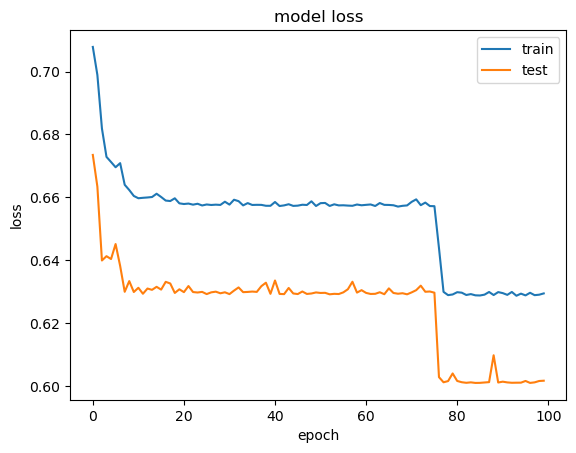

In [66]:
plt.plot(history1['loss'])
plt.plot(history1['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

### Test

In [93]:
with keras.utils.custom_object_scope({"custom_loss": 'mse'}):
    autoencoder1 = keras.models.load_model('fraudSpAE_KL.pth')

In [94]:
predictions1 = autoencoder1.predict(X_test)
mse1 = np.mean(np.power(X_test - predictions1, 2), axis=1)
error_df1 = pd.DataFrame({'reconstruction_error': mse1,
                        'true_class': y_test})
error_df1.describe()

2671/2671 [==============================] - 4s 1ms/step


,reconstruction_error,true_class
count,85443.000000,85443.00000
mean,0.643312,0.00165
std,3.428270,0.04059
min,0.021898,0.00000
25%,0.178658,0.00000
50%,0.310808,0.00000
75%,0.535037,0.00000
max,396.071389,1.00000


In [95]:
threshold1 = 2.9

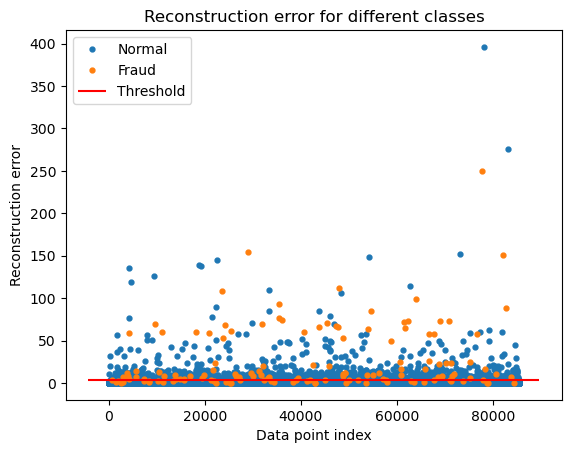

In [96]:
groups = error_df1.groupby('true_class')
fig1, ax1 = plt.subplots()

for name, group in groups:
    ax1.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax1.hlines(threshold1, ax1.get_xlim()[0], ax1.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax1.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

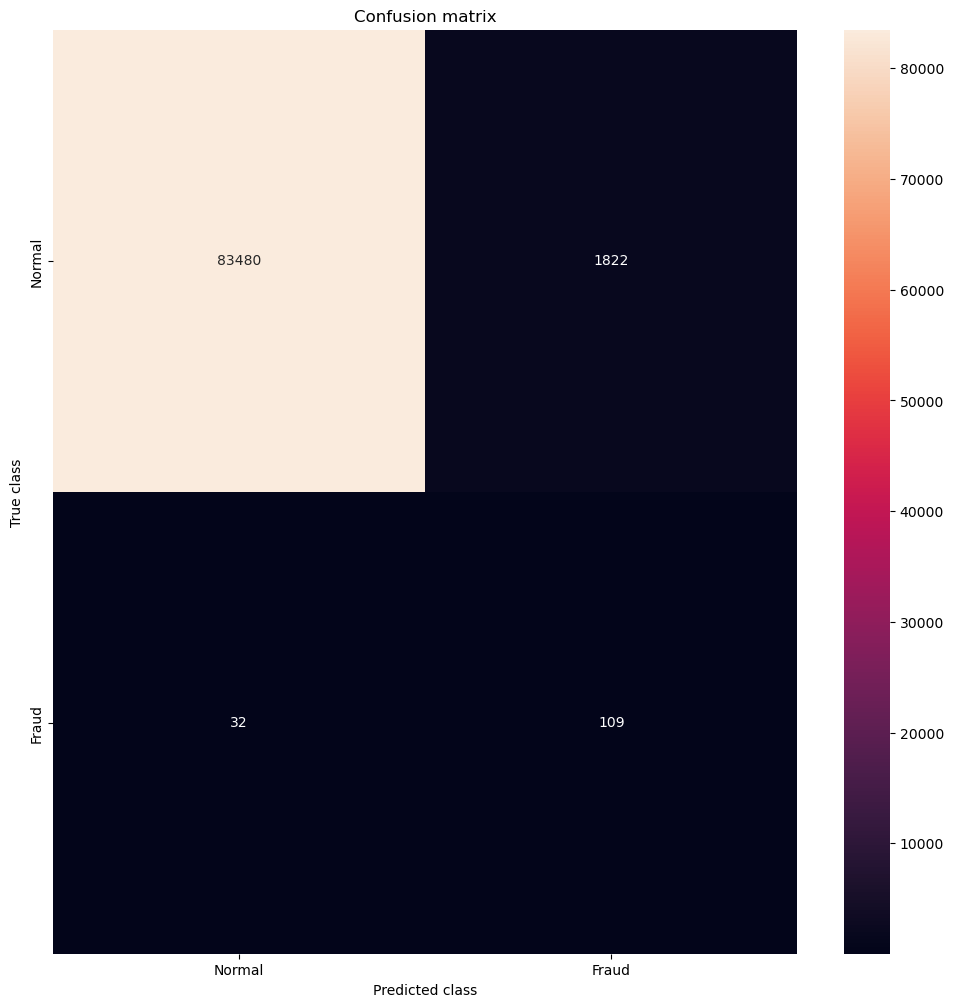

In [97]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
LABELS = ['Normal','Fraud']

y_pred1 = [1 if e > threshold1 else 0 for e in error_df1.reconstruction_error.values]
conf_matrix1 = confusion_matrix(error_df1.true_class, y_pred1)
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix1, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

### Visualize the latent space

In [98]:
inp_layer1 = autoencoder1.input
out_layer1 = autoencoder1.layers[2].output

encoder1 = Model(inputs=inp_layer1, outputs=out_layer1)

In [99]:
encoder1.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 28)]              0         
                                                                 
 dense_19 (Dense)            (None, 40)                1160      
                                                                 
 dense_20 (Dense)            (None, 56)                2296      
                                                                 
Total params: 3456 (13.50 KB)
Trainable params: 3456 (13.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [100]:
fraud1 = X_test[y_test==1]
normal1 = X_test[y_test==0]

features1 = np.append(fraud1, normal1, axis=0)
labels1 = np.append(np.ones(len(fraud1)), np.zeros(len(normal1)))

latent_vector1 = encoder1.predict(features1)

2671/2671 [==============================] - 4s 1ms/step


[0. 0. 0. ... 0. 0. 0.] [0. 0. 0. ... 0. 0. 0.]


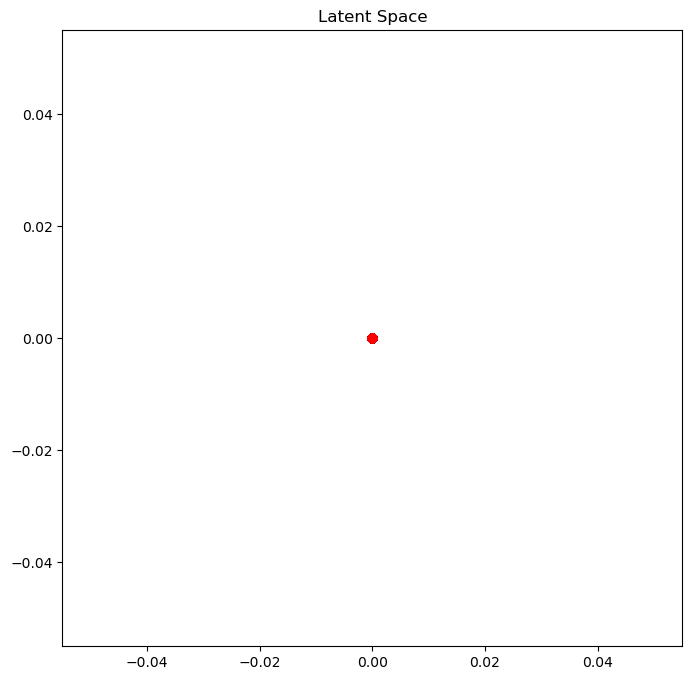

In [101]:
X1 = latent_vector1[:,0]
y1 = latent_vector1[:,1]

print(X1,y1)

plt.subplots(figsize=(8, 8))
plt.scatter(X1[labels1==0], y1[labels1==0], color="blue", label='Normal')
plt.scatter(X1[labels1==1], y1[labels1==1], color="red", label='Fraud')

plt.title('Latent Space')
plt.show()

#TODO 어떤 부분이 문제인지 찾아보기